In [1]:
from aare import Interpolator
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
def calculate_rosenblatt_lookup_table(etacube, etabins_x, etabins_y, etabins_e):

    """ 
        Rosenblatt transform: 
        transforms joint probability P_X,Y to uniform probability between [0,1] U
        U_0 = F_X(x) = P(x' < x) marginal CDF of X
        U_1 = F_Y|X(y|x) = P(y' < y | x) conditional CDF
    """

    #marginal CDF for eta_x
    pEtaX = etacube.sum(axis=1) # marginal distribution eta_x
    CDF_EtaX = np.concatenate([np.zeros(shape=[1, len(etabins_e)]), np.cumsum(pEtaX, axis=0)], axis=0)
    CDF_EtaX = CDF_EtaX / CDF_EtaX[-1] #normalize            

    # conditional CDF F_Y|X (a CDF in y direction for each etaX bin)
    CDF_EtaY_cond = np.cumsum(etacube, axis=1)
    np.divide(CDF_EtaY_cond, np.repeat(pEtaX[:, None, :], len(etabins_y), axis=1), out=np.zeros_like(CDF_EtaY_cond, dtype=np.float64), where=np.repeat(pEtaX[:, None, :], len(etabins_y), axis=1)!=0)

    CDF_EtaY_cond = np.concatenate([np.zeros(shape=[len(etabins_x), 1, len(etabins_e)]), CDF_EtaY_cond], axis=1)
    #CDF_EtaY_cond = CDF_EtaY_cond /  np.where(CDF_EtaY_cond[:,-1:,:] == 0, 1, CDF_EtaY_cond[:,-1:,:]) #normalize

    # calculate (u,v) at the center of each original bin
    """ 
    Xc_1d = 0.5 * (F_EtaX_edges[:-1] + F_EtaX_edges[1:]) # why the average between two values?
    Yc_2d = 0.5 * (F_EtaY_cond_edges[:, :-1] + F_EtaY_cond_edges[:, 1:])

    X_tab = np.repeat(Xc_1d[:, None], nBinY, axis=1)        # (nBinX, nBinY)
    Y_tab = Yc_2d                                           # (nBinX, nBinY)
    """ 
    X_tab = np.repeat(CDF_EtaX[:, None, :], etabins_y.shape[0], axis=1) #TODO: actually does not depend on eta_y at all 
    Y_tab = CDF_EtaY_cond 

    print("shape X_tab: ", X_tab.shape)
    print("shape Y_tab: ", Y_tab.shape)

    return X_tab, Y_tab



Text(0, 0.5, 'y')

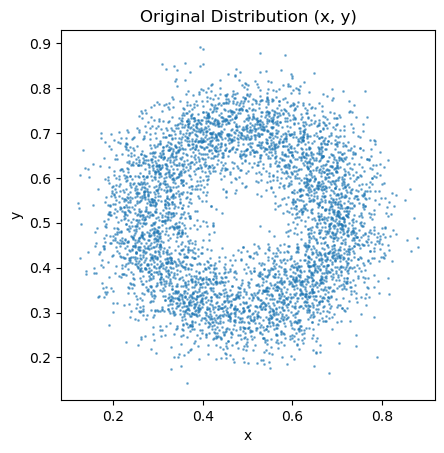

In [3]:
## joint conditional distribution 
rng = np.random.default_rng(42)
n = 10_000_000  
 
## circular distribution x,y dependant 
theta = rng.uniform(0, 4*np.pi, size=n)
r = rng.uniform(0.3, 0.4) 
#r = 0.3 + 0.4 * (theta / (4*np.pi))  # 螺旋半径从 0.3 到 0.7
x_raw = r * np.cos(theta) + 0.1 * rng.normal(size=n)
y_raw = r * np.sin(theta) + 0.1 * rng.normal(size=n)
 
# scale to [0, 1]
x = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())
y = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())
    
plt.scatter(x[:5000], y[:5000], s=1, alpha=0.5)
plt.title("Original Distribution (x, y)")
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
 

In [4]:
def plot(x, y, CDF_X, CDF_Y, u, v): 
    #plot
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
 
    axs[0].scatter(x[:5000], y[:5000], s=1, alpha=0.5)
    axs[0].set_title("Original (x, y)")
    axs[0].set_aspect('equal')
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    
    axs[1].imshow(CDF_X[:,:,0], origin='lower', extent=[0,1,0,1], cmap='viridis')
    axs[1].set_title("normalized CDF_X (u = F_X(x))")
    axs[1].set_xlabel("y")
    axs[1].set_ylabel("P_X(x < x')")

    axs[2].imshow(CDF_Y[:,:,0], origin='lower', extent=[0,1,0,1], cmap='viridis')
    axs[2].set_title("normalized conditional CDF_Y (u = F_Y|X(y|x))")
    axs[2].set_xlabel("P_Y|X(y < y'|x)")
    axs[2].set_ylabel("x")

    axs[3].scatter(u[:5000], v[:5000], s=1, alpha=0.5, color='blue')
    axs[3].set_title("Mapped (u, v)")
    axs[3].set_aspect('equal')
    axs[3].set_xlim(0,1); axs[2].set_ylim(0,1)
    axs[3].set_xlabel("u")
    axs[3].set_ylabel("v")
    
    plt.tight_layout()
    plt.show()

In [5]:
#calculate joint probability density function
nBins = 300
range = np.array([[x.min(),x.max()], [y.min(),y.max()]])
bin_width = (range[:,0] - range[:,1])/nBins
H, xedges, yedges = np.histogram2d(x, y, bins=nBins, range=range)
H = H.astype(int) 
H = np.repeat(H[:,:,None], 2, axis=2) #add energy axis

print(H.shape)
ebins = [0,1,2] #dummy energy bins

(300, 300, 2)


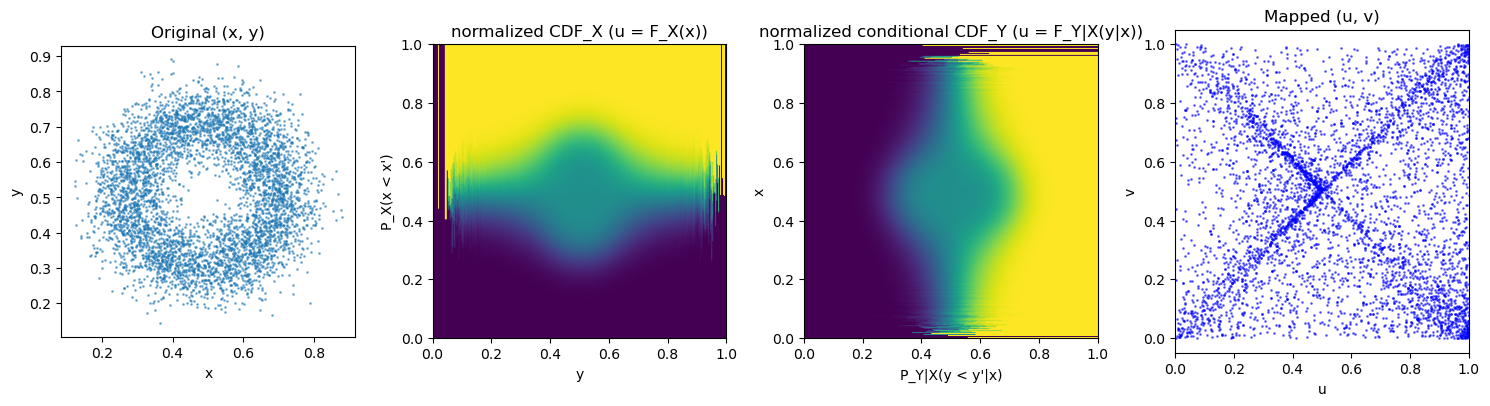

In [7]:
## check that interpolator transforms to uniform distribution 
interpolator = Interpolator(H, xedges[:-1], yedges[:-1], ebins[:-1]) #dummy energy bins
CDF_X = interpolator.get_ietax() #lookup table x 
CDF_Y = interpolator.get_ietay() #lookup table y 

x_indices = ((x - range[0,0])/bin_width[0]).astype(int)
y_indices = ((y - range[1,0])/bin_width[1]).astype(int)

u = CDF_X[x_indices, y_indices, 0] #transformed to uniform coordinates
v = CDF_Y[x_indices, y_indices, 0] #transformed to uniform coordinates

plot(x,y,CDF_X,CDF_Y, u,v)


shape X_tab:  (301, 300, 2)
shape Y_tab:  (300, 301, 2)


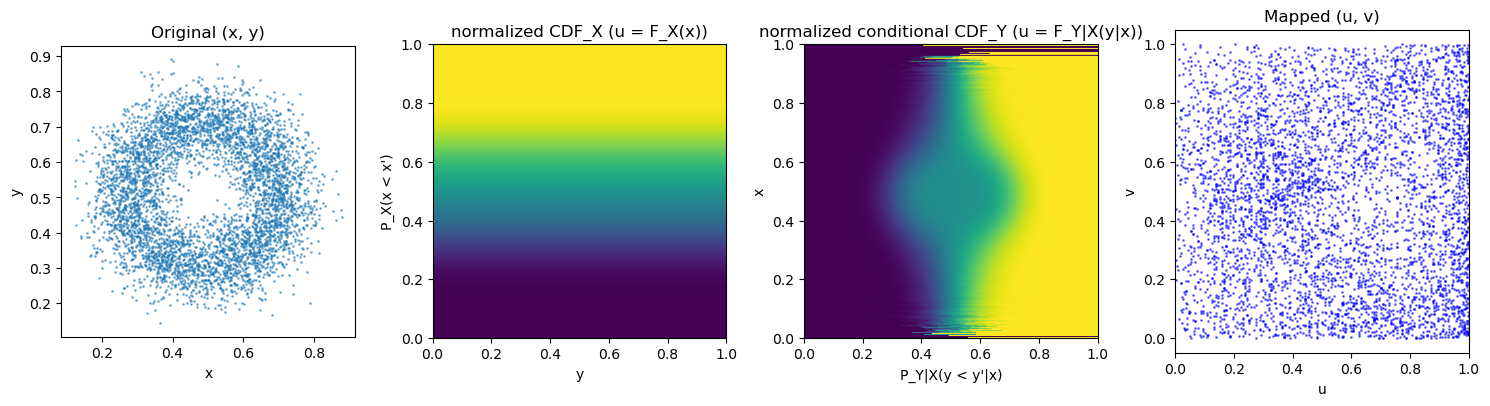

In [9]:
x_indices = ((x - range[0,0])/bin_width[0]).astype(int)
y_indices = ((y - range[1,0])/bin_width[1]).astype(int)

CDF_X, CDF_Y = calculate_rosenblatt_lookup_table(H, xedges[:-1], yedges[:-1],ebins[:-1])

u = CDF_X[x_indices, y_indices, 0] #transformed to uniform coordinates
v = CDF_Y[x_indices, y_indices, 0] #transformed to uniform coordinates
 
plot(x,y,CDF_X,CDF_Y, u,v)

worked: 
could normalize CDF eta_x
construction worked
calculation of conditional CDF etay worked
assignment m_ietay worked
assignment m_ietax worked


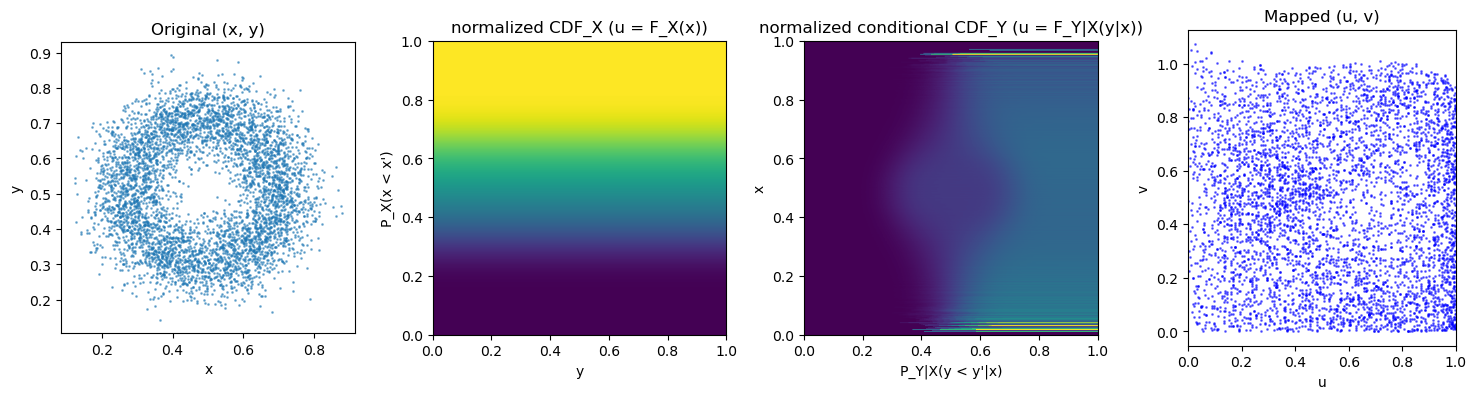

In [6]:
## check that cpp rosenblatt transforms to uniform distribution 
interpolator = Interpolator(xedges[:-1], yedges[:-1], ebins[:-1]) #dummy energy bins
interpolator.rosenblatttransform(H)
CDF_X = interpolator.get_ietax() #lookup table x 
CDF_Y = interpolator.get_ietay() #lookup table y 

x_indices = ((x - range[0,0])/bin_width[0]).astype(int)
y_indices = ((y - range[1,0])/bin_width[1]).astype(int)

u = CDF_X[x_indices, y_indices, 0] #transformed to uniform coordinates
v = CDF_Y[x_indices, y_indices, 0] #transformed to uniform coordinates

plot(x,y,CDF_X,CDF_Y, u,v)